In [ ]:
#!git clone https://github.com/NewtonsFlamingLaserSword/steering_angle_modelv2

In [ ]:
#!ls steering_angle_modelv2

In [ ]:
!pip3 install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
datadir = '/content/gdrive/My Drive/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head() 
#'/content/gdrive/My Drive/foo.txt'

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\center_2019_01_19_16_25_16_218.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\left_2019_01_19_16_25_16_218.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\right_2019_01_19_16_25_16_218.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\center_2019_01_19_16_25_16_319.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\left_2019_01_19_16_25_16_319.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\right_2019_01_19_16_25_16_319.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\center_2019_01_19_16_25_16_420.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\left_2019_01_19_16_25_16_420.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\right_2019_01_19_16_25_16_420.jpg,0.0,0.0,0.0,0.000078
3,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\center_2019_01_19_16_25_16_521.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\left_2019_01_19_16_25_16_521.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\right_2019_01_19_16_25_16_521.jpg,0.0,0.0,0.0,0.000079
4,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\center_2019_01_19_16_25_16_622.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\left_2019_01_19_16_25_16_622.jpg,C:\Users\Aiel\Downloads\simulator-windows-64\IMG\right_2019_01_19_16_25_16_622.jpg,0.0,0.0,0.0,0.000079


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_01_19_16_25_16_218.jpg,left_2019_01_19_16_25_16_218.jpg,right_2019_01_19_16_25_16_218.jpg,0.0,0.0,0.0,0.000081
1,center_2019_01_19_16_25_16_319.jpg,left_2019_01_19_16_25_16_319.jpg,right_2019_01_19_16_25_16_319.jpg,0.0,0.0,0.0,0.000081
2,center_2019_01_19_16_25_16_420.jpg,left_2019_01_19_16_25_16_420.jpg,right_2019_01_19_16_25_16_420.jpg,0.0,0.0,0.0,0.000078
3,center_2019_01_19_16_25_16_521.jpg,left_2019_01_19_16_25_16_521.jpg,right_2019_01_19_16_25_16_521.jpg,0.0,0.0,0.0,0.000079
4,center_2019_01_19_16_25_16_622.jpg,left_2019_01_19_16_25_16_622.jpg,right_2019_01_19_16_25_16_622.jpg,0.0,0.0,0.0,0.000079


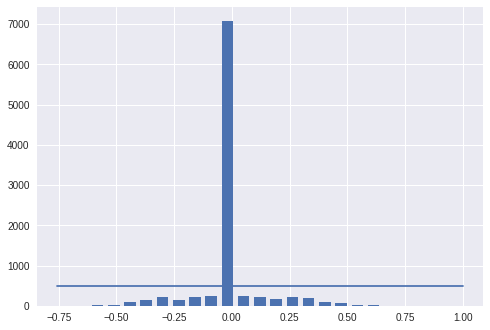

In [ ]:
num_bins = 25
samples_per_bin = 500 #deleting too much data with 0 steering angle could cause the AI to wiggle on the road
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 9449
removed: 6575
remaining: 2874


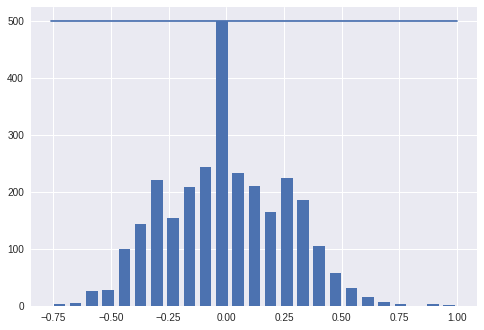

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    #left image append
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    #right image append
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_19_16_25_18_142.jpg
left        left_2019_01_19_16_25_18_142.jpg  
right       right_2019_01_19_16_25_18_142.jpg 
steering   -0.397155                          
throttle    0.397155                          
reverse     0                                 
speed       0.365112                          
Name: 19, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 6897
Valid Samples: 1725


Text(0.5, 1.0, 'Validation set')

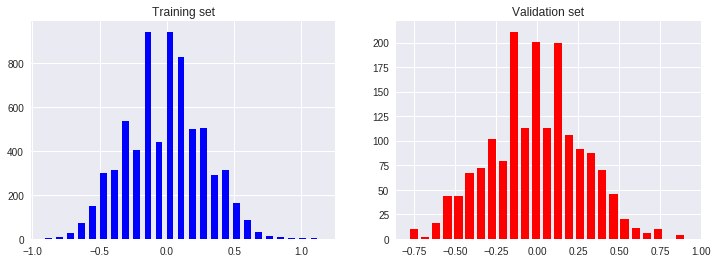

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed_image')

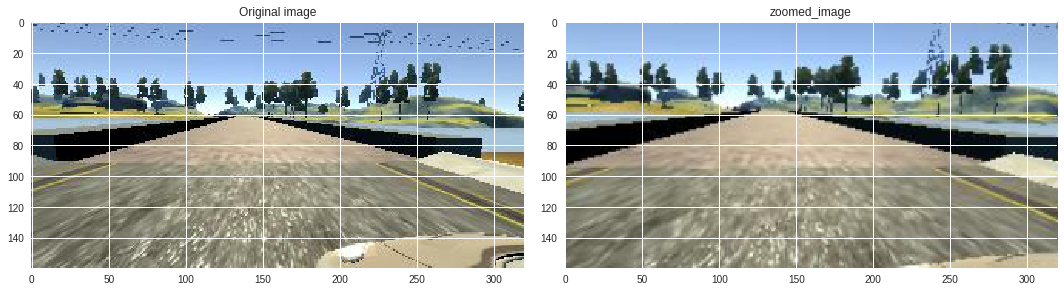

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed_image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle
  
  

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5 :
    image = pan(image)
  if np.random.rand() < 0.5 :
    image = zoom(image)
  if np.random.rand() < 0.5 :
    image = img_random_brightness(image)
  if np.random.rand() < 0.5 :
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

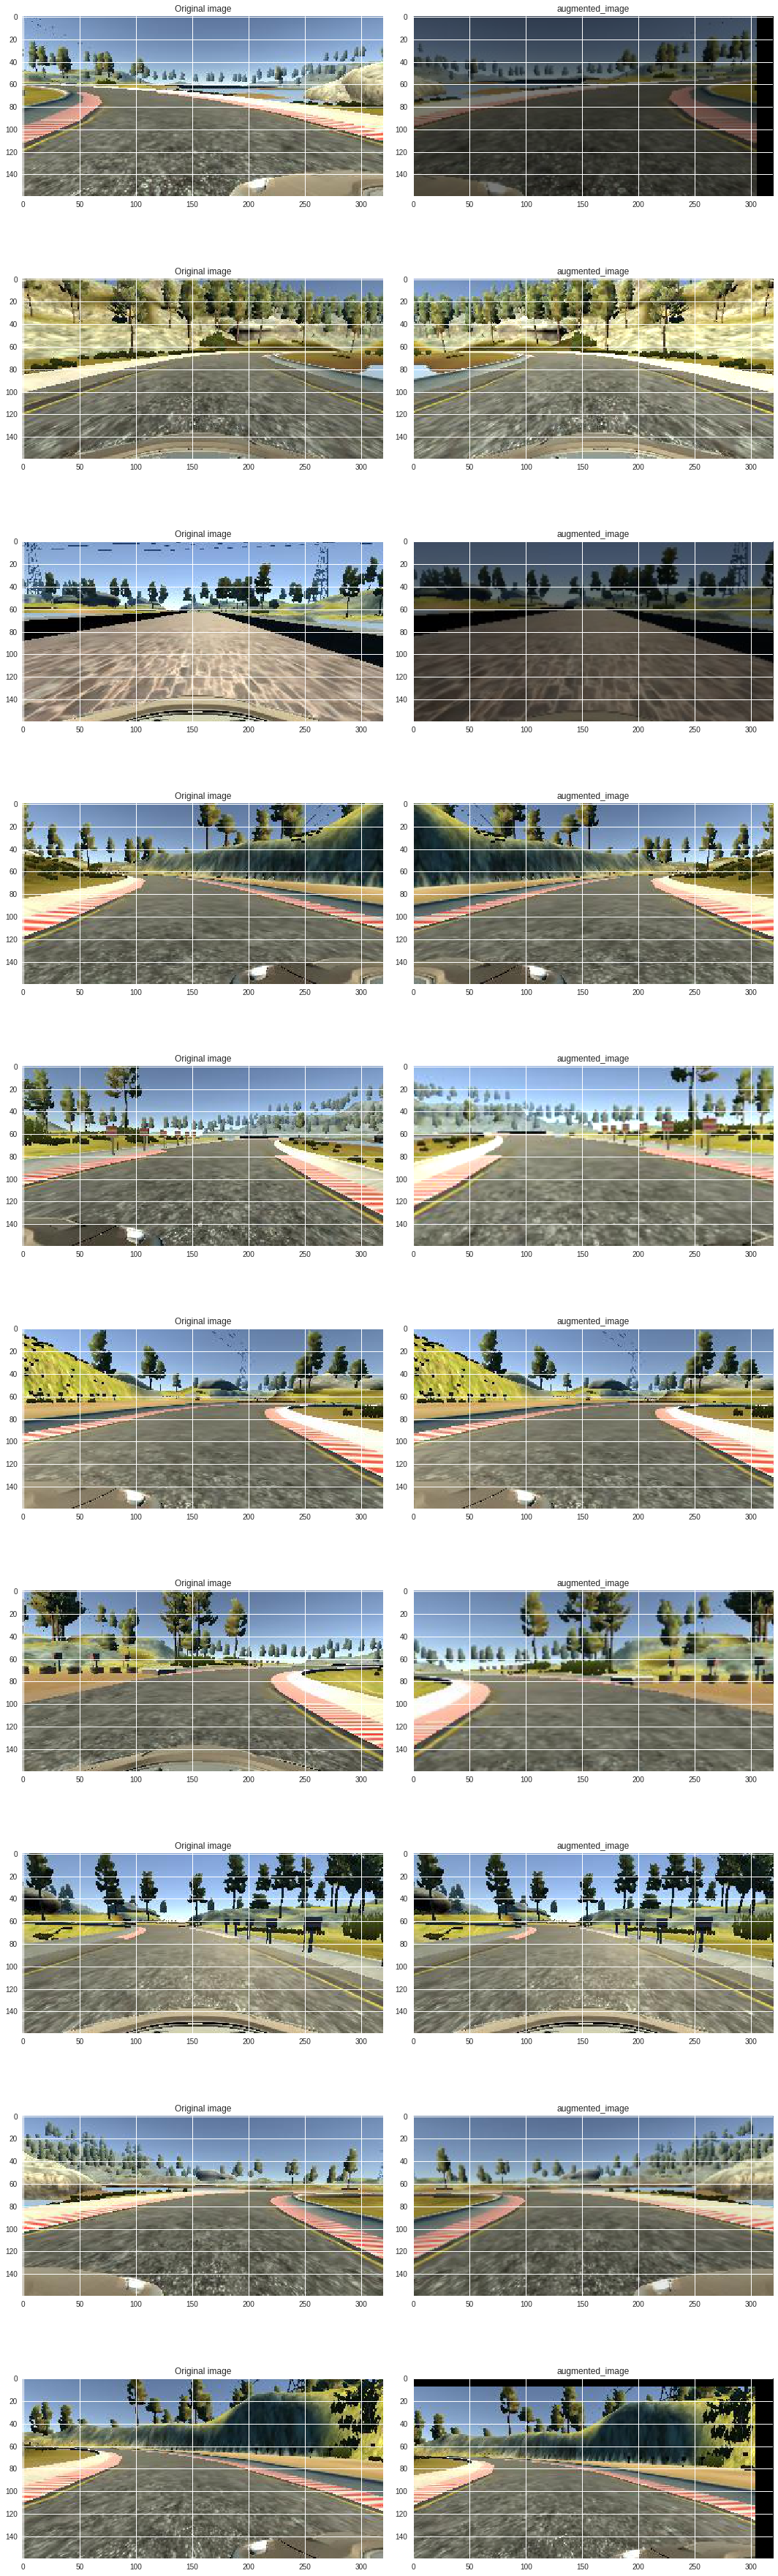

In [ ]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('augmented_image')

In [ ]:
def img_preprocess(img):
  img = img[60 : 135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #necessary for Nvidia model
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66)) #necessary for Nvidia model
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed image')

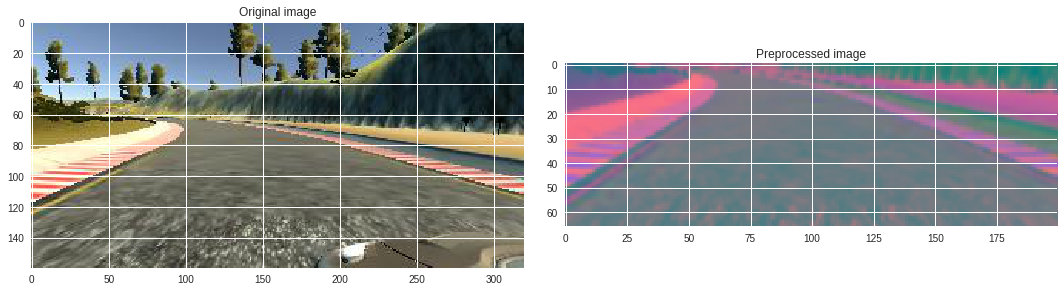

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
        
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield (np.asarray(batch_img), np.asarray(batch_steering))
    

Text(0.5, 1.0, 'Validation image')

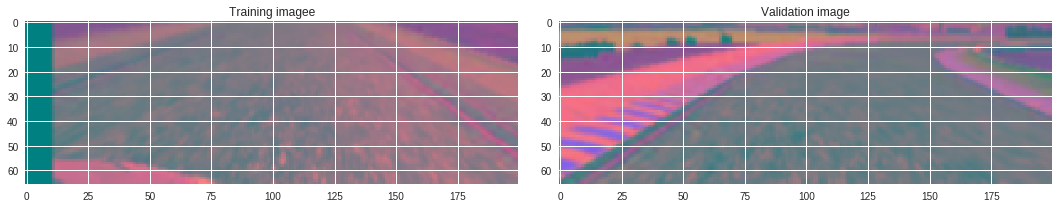

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training imagee')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation image')

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model
  

In [ ]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys


In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=100, epochs = 10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, verbose = 1, shuffle = 1)

Epoch 1/10
100/100 [==============================] - 397s 4s/step - loss: 0.0654 - val_loss: 0.0383
Epoch 2/10
100/100 [==============================] - 222s 2s/step - loss: 0.0512 - val_loss: 0.0383
Epoch 3/10
100/100 [==============================] - 195s 2s/step - loss: 0.0466 - val_loss: 0.0379
Epoch 4/10
100/100 [==============================] - 191s 2s/step - loss: 0.0453 - val_loss: 0.0397
Epoch 5/10
100/100 [==============================] - 189s 2s/step - loss: 0.0433 - val_loss: 0.0337
Epoch 6/10
100/100 [==============================] - 189s 2s/step - loss: 0.0416 - val_loss: 0.0335
Epoch 7/10
100/100 [==============================] - 186s 2s/step - loss: 0.0413 - val_loss: 0.0333
Epoch 8/10
100/100 [==============================] - 188s 2s/step - loss: 0.0392 - val_loss: 0.0335
Epoch 9/10
100/100 [==============================] - 187s 2s/step - loss: 0.0401 - val_loss: 0.0316
Epoch 10/10
100/100 [==============================] - 184s 2s/step - loss: 0.0384 - val_lo

Text(0.5, 0, 'Epoch')

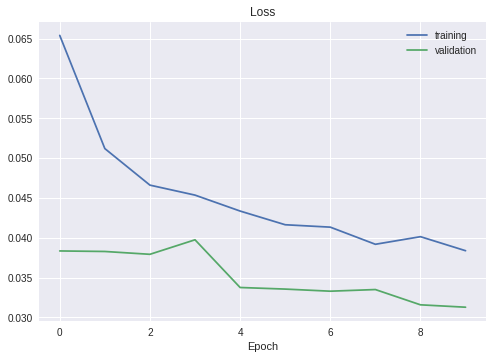

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')